In [572]:
import numpy as np
import pandas as pd
import os,sys,inspect
import scipy.stats as stats
import scipy.optimize as opt
from scipy.io import loadmat
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import itertools as it
import copy

# mine
# (1)
import demand_discrete_choice.DiscreteChoice as dc

# (2)
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import myfunctions as mf

import importlib
importlib.reload(dc)
importlib.reload(mf)

<module 'myfunctions' from '/Users/jingyuanwang/GitHub/NU450_HW/myfunctions.py'>

In [573]:
# ------------------------------------------------------------------------
# NOTE
# ------------------------------------------------------------------------
# Purpose: HW2 
# 
# Import data and stats
# 
#
# ------------------------------------------------------------------------

# Initialize file path

In [574]:
rootpath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-1-HW2'
datapath = rootpath + '/' + 'data'
resultpath = rootpath + '/' + 'results'

# Parameters
Everything should be input in the following cell. 
All other cells are just operation and calculation.

In [575]:
# model parameters (true value)
true_parameters = {'beta': np.array([5,1,1]),
                   'alpha_0': 1,
                   'alpha_sigma':1,
                   'gamma': np.array([2,1,1])}

# import file names
matfiles = ['10markets3products', '100markets3products','100markets5products']
names = ['m10_prod3', 'm100_prod3', 'm100_prod5']

# Import Data

In [576]:
# 1 import
inputfiles = dict(zip(names, matfiles))
data = {}
for name, filename in inputfiles.items():
    file = datapath + '/Simulation Data/'+ filename
    data[name] = loadmat(file)


In [616]:
# 2. clean and save to a class
num_of_market = 100
num_of_prod = 3
sample = 'm{}_prod{}'.format(num_of_market,num_of_prod)


df_product = (pd.DataFrame(np.concatenate( 
                          (data[sample]['x1'],
                           data[sample]['xi_all'],
                           data[sample]['w'], 
                           data[sample]['Z'],
                           data[sample]['eta']), axis = 1 ))
              .rename(columns = {0:'x1',1:'x2',2:'x3',3:'xi', 4:'w', 5:'z',6:'eta'}) )
df_product['price'] = np.reshape(data[sample]['P_opt'], (num_of_market*num_of_prod,1))

df_product['market_id'] = np.repeat(np.arange(num_of_market)[:,np.newaxis], num_of_prod, axis = 0)

df_product['product_id'] = (np.repeat(np.arange(num_of_prod)[:, np.newaxis], 
                                      num_of_market, axis=1)
                                .reshape((num_of_prod*num_of_market,1), order = 'F') )
product_ids = {'market_id':'market_id',
               'product_id':'product_id'}

# consumer
df_consumer = pd.DataFrame(data[sample]['alphas'].T, columns=[idx for idx in range(num_of_market) ])
df_consumer = df_consumer.stack().reset_index().rename(columns = {'level_0':'consumer_id', 
                                                                  'level_1':'market_id',
                                                                  0:'alpha'})


consumer_ids = {'market_id':'market_id',
               'consumer_id':'consumer_id'}


In [617]:
# 3. fit it into a class: discrete choice

#demand_m10_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)
demand_m100_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)
#demand_m100_prod5 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)


# Q1. Simulate consumer choice and welfare

## simulate

In [618]:
product_attribute_observed = ['x1','x2','x3']
product_attribute_unobs = 'xi'
eps = 'eps_ijm'
price = 'price'
taste = demand_m100_prod3.true_par['beta']
price_sensitivity = 'alpha'

demand_m100_prod3.simulate_consumer_choice(product_attribute_observed, product_attribute_unobs, price,
                                    taste, price_sensitivity, eps)


Total welfare = 878287.6929224161


In [619]:
cost_attribute_observed = ['w', 'z']
cost_input_coeff = demand_m100_prod3.true_par['gamma']
error_term = 'eta'

demand_m100_prod3.simulate_firm_profit(cost_attribute_observed, price, cost_input_coeff, error_term)

Total Profits of each firm (product) = 
            total_profit
product_id              
0           11392.893024
1           44383.194562
2           36024.375563


## Plot

In [620]:
path = resultpath + '/' + 'Q1'

# demand system:
demand_sys = demand_m100_prod3
num_m = 100
num_prod = 3

1. price:

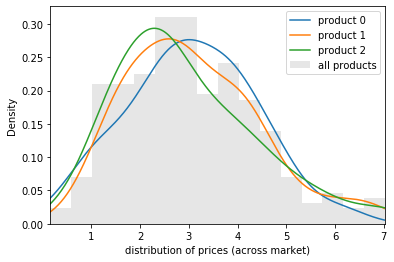

In [621]:
mf.hist_and_kdensity_bygroup(demand_sys.products, 'price', 
                        var_label = 'distribution of prices (across market)', 
                        groupname = 'product_id', group_label = 'product',
                            save = True, figpath= path, figname = 'dist_price_m{}_prod{}'.format(num_m,num_prod))

2. firms' profits

--- Firm Sales ---


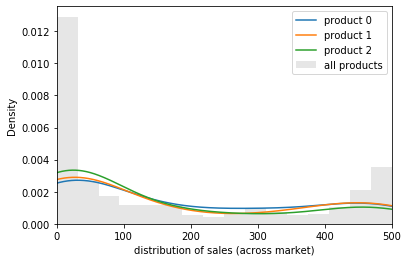

--- Firm Profits ---


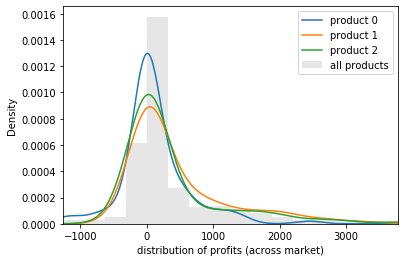

In [622]:
print('--- Firm Sales ---')
mf.hist_and_kdensity_bygroup(demand_sys.products, 'sales', 
                        var_label = 'distribution of sales (across market)', 
                        groupname = 'product_id', group_label = 'product')
print('--- Firm Profits ---')
mf.hist_and_kdensity_bygroup(demand_sys.products, 'profit_jm', 
                        var_label = 'distribution of profits (across market)', 
                        groupname = 'product_id', group_label = 'product',  
                             save = True, figpath= path, figname = 'dist_profit_m{}_prod{}'.format(num_m,num_prod))


3. utility and welfare

------ Welfare ------
Welfare distribution for all markets:


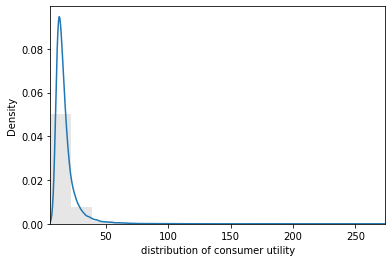

In [623]:
print('------ Welfare ------')
print('Welfare distribution for all markets:')
mf.hist_and_kdensity(demand_sys.consumers['utility'], var_label = 'distribution of consumer utility',
                     save = True, figpath= path, figname = 'dist_welfare_m{}_prod{}'.format(num_m,num_prod))

Welfare distribution in market 58:


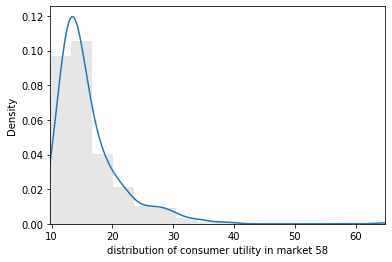

In [624]:
# one specific market
market = 58
print('Welfare distribution in market {}:'.format(market))
mf.hist_and_kdensity(demand_sys.consumers.loc[demand_sys.consumers['market_id']==market, 'utility'],
                      var_label = 'distribution of consumer utility in market {}'.format(market))

# Q2. Estimation: Demand side instrument

In [179]:
num_of_market = max(len(df_product[consumer_ids['market_id']].unique()),  
                            len(df_product[product_ids['market_id']].unique()) )

In [185]:
max_num_of_consumer_withinmarket = df_consumer[consumer_ids].groupby(consumer_ids['market_id']).count().max()
max_num_of_prod_withinmarket = df_product[product_ids].groupby(product_ids['market_id']).count().max()

In [187]:
max_num_of_prod_withinmarket

product_id    3
dtype: int64

In [170]:
df_panel = pd.merge(panel_index, df_product, 
                 how= 'right',
                 left_on = [ panel_ids[key] for key in ('market_id','product_id')],
                 right_on =  list(product_ids.values()) )

In [174]:
df_panel.iloc[0:500,]

In [175]:
df_panel.sort_index(inplace = True)

In [ ]:
demand_m10_prod3.consumer_product.apply( lambda x: x+y, axis)

In [ ]:
df['']= demand_m10_prod3.consumer_product.head().apply(lambda row : row.x1 + row.x2, axis=1)

In [ ]:
# Outline
# 1. simulate choice
# 2. compare with the given market share variable
# 3. save observables and final choice as a sample dataset. Make this a class
# 4. calculate welfare

In [ ]:
#1. answer questions

In [ ]:
#2. estimate delta and xi, compare with real data